In [1]:
import pandas as pd

# Load the dataset
file_path = 'Tweets.csv'
tweets_df = pd.read_csv(file_path)

# Display the first few rows of the dataset
tweets_df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [2]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources (stopwords, punkt tokenizer)
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Define a function for text cleaning
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet text
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Lowercase the text
    text = text.lower()
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stop_words]
    # Join words back to string
    return " ".join(filtered_words)

# Apply the cleaning function to the text column
tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_text)

# Display the first few cleaned texts
tweets_df[['text', 'cleaned_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text,cleaned_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing


In [3]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features for efficiency

# Fit and transform the cleaned text data
X_tfidf = tfidf_vectorizer.fit_transform(tweets_df['cleaned_text'])

# Display the shape of the resulting TF-IDF matrix
X_tfidf.shape


(14640, 5000)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Extract the target variable (sentiment)
y = tweets_df['airline_sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = nb_classifier.predict(X_test)

# Evaluate the model
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_classification_report = classification_report(y_test, y_pred_nb)

(nb_accuracy, nb_classification_report)


(0.7397540983606558,
 '              precision    recall  f1-score   support\n\n    negative       0.73      0.98      0.84      1889\n     neutral       0.72      0.25      0.37       580\n    positive       0.88      0.37      0.52       459\n\n    accuracy                           0.74      2928\n   macro avg       0.78      0.53      0.57      2928\nweighted avg       0.75      0.74      0.69      2928\n')

In [5]:
from sklearn.svm import LinearSVC

# Initialize and train the SVM classifier
svm_classifier = LinearSVC()
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_classification_report = classification_report(y_test, y_pred_svm)

(svm_accuracy, svm_classification_report)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


(0.7906420765027322,
 '              precision    recall  f1-score   support\n\n    negative       0.84      0.90      0.87      1889\n     neutral       0.61      0.52      0.56       580\n    positive       0.77      0.68      0.72       459\n\n    accuracy                           0.79      2928\n   macro avg       0.74      0.70      0.72      2928\nweighted avg       0.78      0.79      0.78      2928\n')

In [7]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer



# Tokenize and convert texts to sequences for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets_df['cleaned_text'])
X_sequences = tokenizer.texts_to_sequences(tweets_df['cleaned_text'])

# Pad sequences to ensure uniform input size
max_sequence_length = 100
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

# Convert the target variable to numerical format
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y_numeric = tweets_df['airline_sentiment'].map(sentiment_mapping)
y_categorical = to_categorical(y_numeric, num_classes=3)

# Split data into training and testing sets
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length))
lstm_model.add(LSTM(units=128, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(3, activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=64, validation_data=(X_test_seq, y_test_seq), verbose=2)

# Evaluate the model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)
lstm_accuracy


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


183/183 - 67s - 365ms/step - accuracy: 0.6928 - loss: 0.7322 - val_accuracy: 0.7814 - val_loss: 0.5664
Epoch 2/5
183/183 - 83s - 453ms/step - accuracy: 0.8160 - loss: 0.4651 - val_accuracy: 0.7978 - val_loss: 0.5193
Epoch 3/5
183/183 - 80s - 435ms/step - accuracy: 0.8648 - loss: 0.3559 - val_accuracy: 0.7848 - val_loss: 0.5660
Epoch 4/5
183/183 - 82s - 448ms/step - accuracy: 0.8939 - loss: 0.2925 - val_accuracy: 0.7941 - val_loss: 0.5921
Epoch 5/5
183/183 - 62s - 338ms/step - accuracy: 0.9062 - loss: 0.2508 - val_accuracy: 0.7876 - val_loss: 0.6692


0.7875683307647705

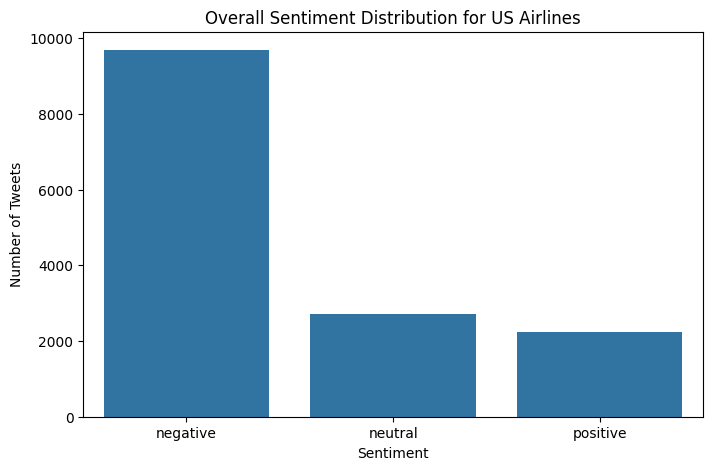

,proportion
predicted_sentiment,
negative,66.140710
neutral,18.606557
positive,15.252732


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add the SVM predictions to the dataframe for analysis
tweets_df['predicted_sentiment'] = svm_classifier.predict(X_tfidf)

# Plot the overall sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='predicted_sentiment', data=tweets_df, order=['negative', 'neutral', 'positive'])
plt.title('Overall Sentiment Distribution for US Airlines')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

# Sentiment distribution
sentiment_distribution = tweets_df['predicted_sentiment'].value_counts(normalize=True) * 100
sentiment_distribution


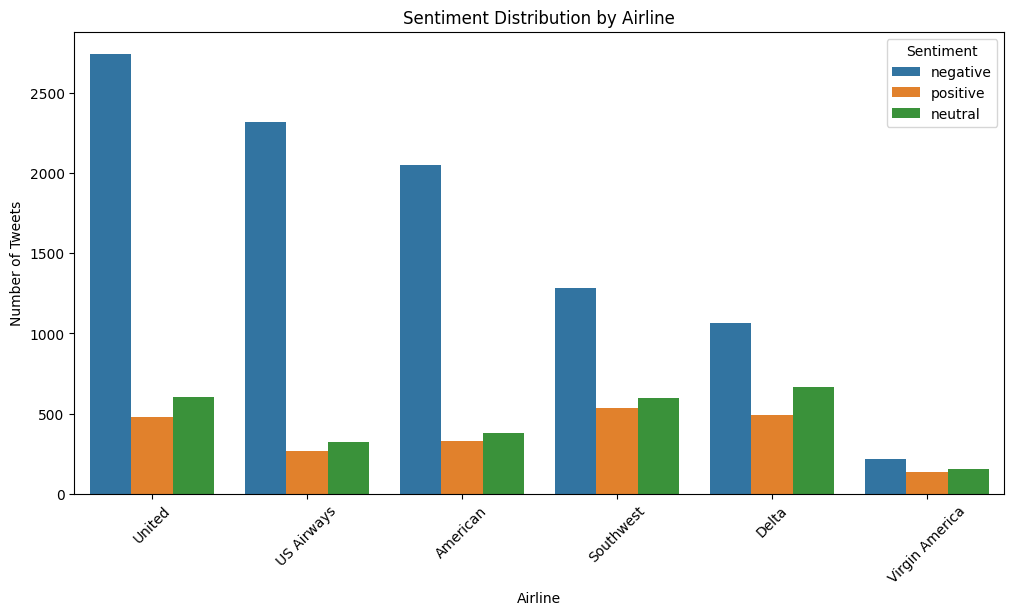

predicted_sentiment,negative,neutral,positive
airline,,,
American,74.338528,13.736861,11.924610
Delta,47.974797,30.018002,22.007201
Southwest,53.099174,24.669421,22.231405
US Airways,79.677309,11.191212,9.131480
United,71.821036,15.724751,12.454212
Virgin America,42.658730,30.555556,26.785714


In [9]:
# Plot sentiment distribution for each airline
plt.figure(figsize=(12, 6))
sns.countplot(x='airline', hue='predicted_sentiment', data=tweets_df, order=tweets_df['airline'].value_counts().index)
plt.title('Sentiment Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()

# Calculate sentiment distribution by airline
sentiment_by_airline = tweets_df.groupby('airline')['predicted_sentiment'].value_counts(normalize=True).unstack() * 100
sentiment_by_airline


In [11]:
# Filter tweets based on sentiment
negative_tweets = tweets_df[tweets_df['predicted_sentiment'] == 'negative']
neutral_tweets = tweets_df[tweets_df['predicted_sentiment'] == 'neutral']
positive_tweets = tweets_df[tweets_df['predicted_sentiment'] == 'positive']

# Analyze common words in negative tweets
negative_words = " ".join(negative_tweets['cleaned_text'].tolist())
negative_word_freq = pd.Series(negative_words.split()).value_counts().head(20)

# Analyze common words in neutral tweets
neutral_words = " ".join(neutral_tweets['cleaned_text'].tolist())
neutral_word_freq = pd.Series(neutral_words.split()).value_counts().head(20)

# Analyze common words in positive tweets
positive_words = " ".join(positive_tweets['cleaned_text'].tolist())
positive_word_freq = pd.Series(positive_words.split()).value_counts().head(20)

(negative_word_freq, neutral_word_freq, positive_word_freq)


(flight       3045
 get          1035
 cancelled     975
 service       766
 hours         668
 help          635
 customer      627
 time          619
 hold          618
 im            567
 us            548
 plane         542
 still         518
 cant          513
 delayed       509
 amp           500
 flightled     472
 call          468
 hour          453
 one           453
 Name: count, dtype: int64,
 flight      515
 get         203
 please      179
 need        152
 flights     150
 help        142
 fleek       131
 fleets      128
 dm          124
 thanks      123
 “           108
 im          101
 would       100
 know         97
 tomorrow     85
 us           78
 way          77
 change       76
 amp          75
 number       73
 Name: count, dtype: int64,
 thanks      611
 thank       478
 flight      334
 great       244
 service     149
 love        133
 best        111
 much        108
 good        107
 customer    104
 guys        103
 awesome     101
 got         100
 ge

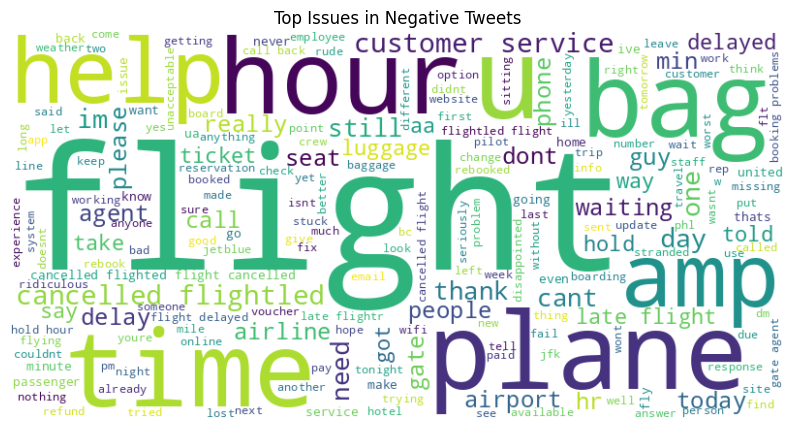

In [12]:
from wordcloud import WordCloud

# Create a word cloud for negative sentiment
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Plot the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Top Issues in Negative Tweets')
plt.axis('off')
plt.show()


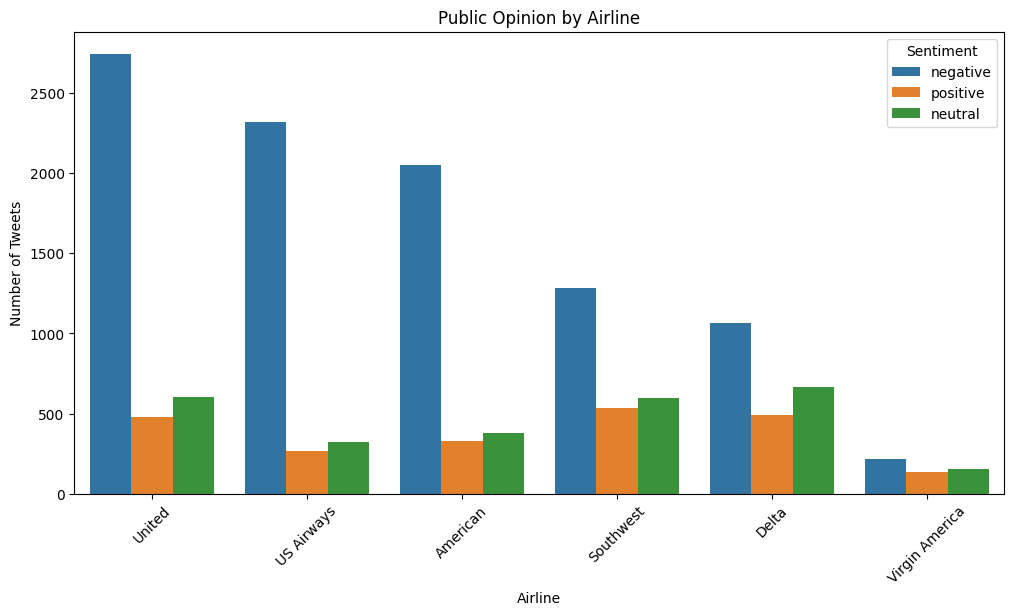

In [13]:
# Plot sentiment distribution for each airline
plt.figure(figsize=(12, 6))
sns.countplot(x='airline', hue='predicted_sentiment', data=tweets_df, order=tweets_df['airline'].value_counts().index)
plt.title('Public Opinion by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()


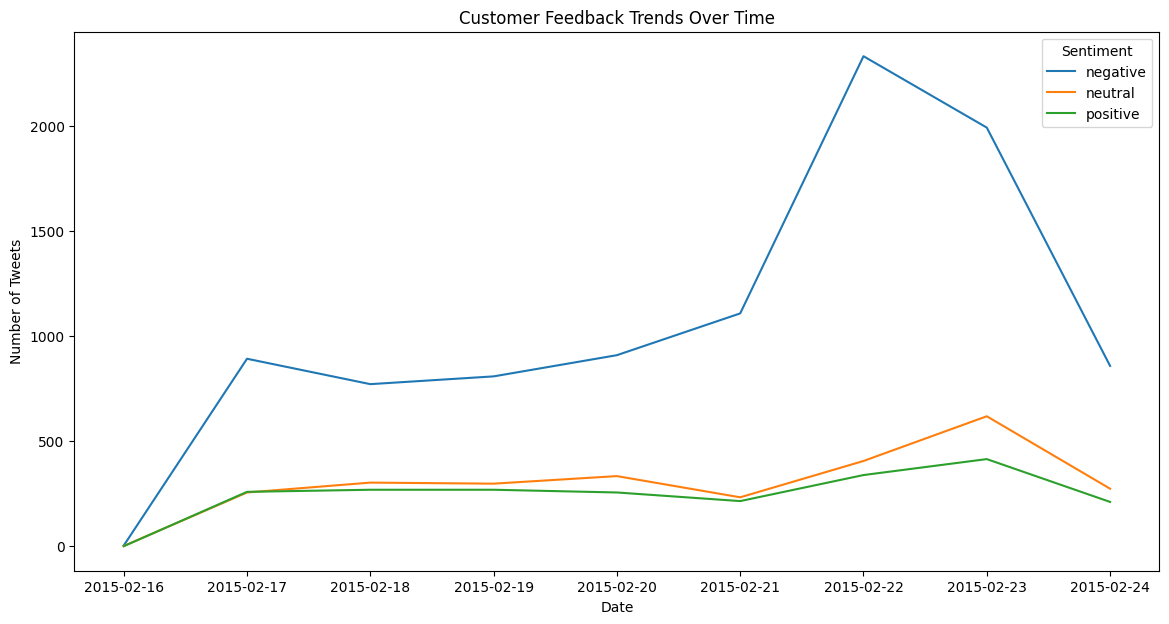

In [14]:
# Convert tweet_created to datetime
tweets_df['tweet_created'] = pd.to_datetime(tweets_df['tweet_created'])

# Extract the date from the timestamp
tweets_df['tweet_date'] = tweets_df['tweet_created'].dt.date

# Aggregate sentiments by date
sentiment_over_time = tweets_df.groupby(['tweet_date', 'predicted_sentiment']).size().unstack().fillna(0)

# Plot sentiment trends over time
plt.figure(figsize=(14, 7))
sentiment_over_time.plot(kind='line', ax=plt.gca())
plt.title('Customer Feedback Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')
plt.show()


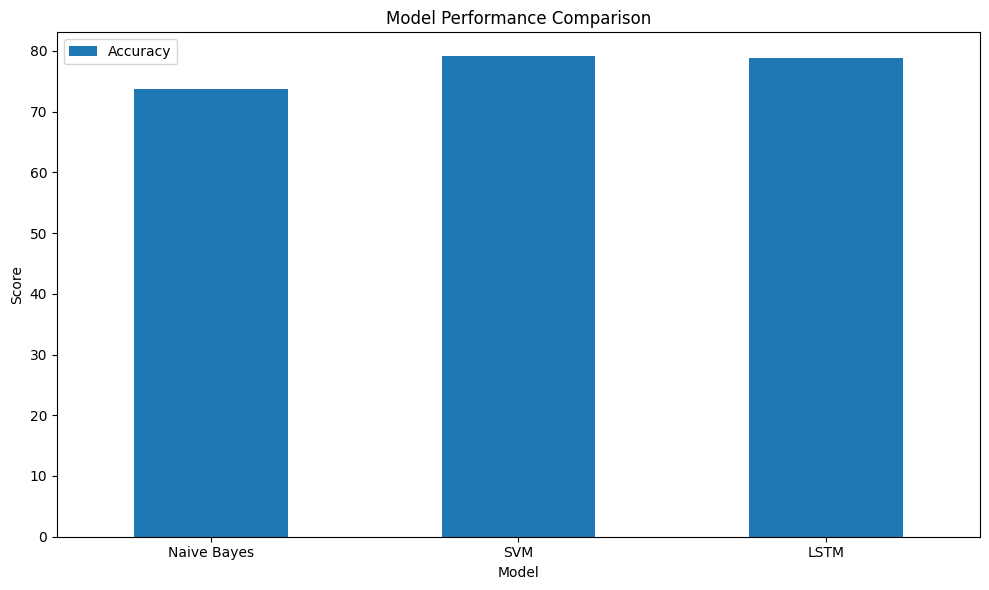

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Model Performance Data
performance_data = {
    'Model': ['Naive Bayes', 'SVM', 'LSTM'],
    'Accuracy': [73.8, 79.1, 78.8],
    'F1-Score (Negative)': [0.84, 0.87, 0.86],
    'F1-Score (Positive)': [0.52, 0.72, 0.70]
}

# Create a DataFrame
performance_df = pd.DataFrame(performance_data)

# Plot the Model Performance Comparison
performance_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


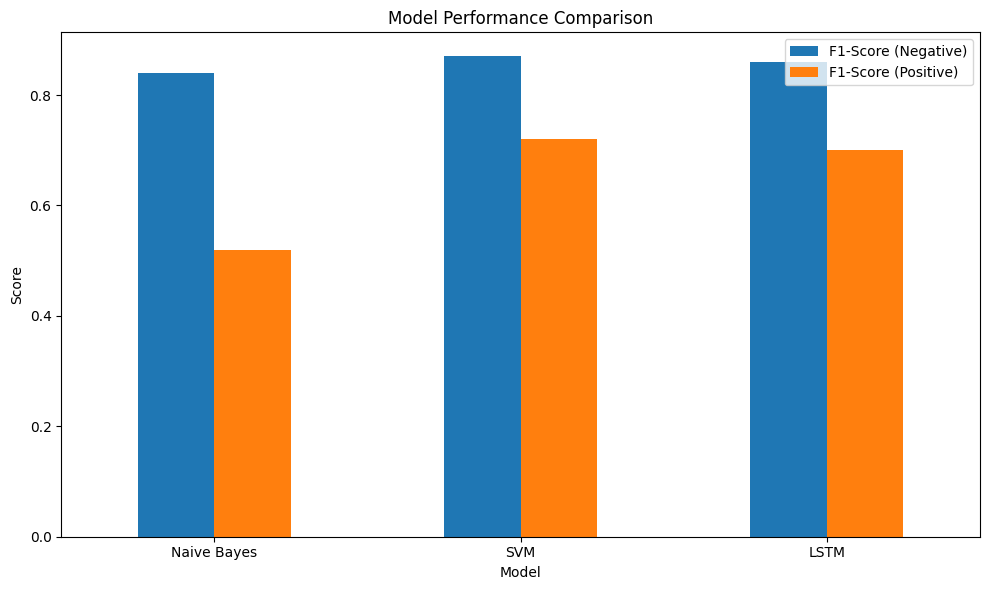

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Model Performance Data
performance_data = {
    'Model': ['Naive Bayes', 'SVM', 'LSTM'],
    'F1-Score (Negative)': [0.84, 0.87, 0.86],
    'F1-Score (Positive)': [0.52, 0.72, 0.70]
}

# Create a DataFrame
performance_df = pd.DataFrame(performance_data)

# Plot the Model Performance Comparison
performance_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


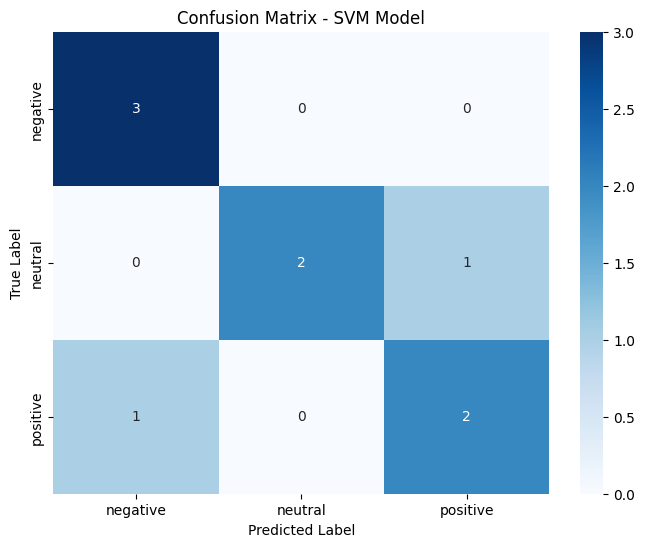

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example actual and predicted sentiment labels
y_true = ['negative', 'neutral', 'positive', 'negative', 'positive', 'neutral', 'negative', 'positive', 'neutral']
y_pred = ['negative', 'neutral', 'negative', 'negative', 'positive', 'neutral', 'negative', 'positive', 'positive']

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])

# Add titles and labels
plt.title('Confusion Matrix - SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the heatmap
plt.show()
